In [16]:
import numpy as np
from PIL import Image, ImageDraw
import glob, os, shutil,sys
import csv as csv
from sklearn.utils import shuffle
from parsing import *
from utils import *
from anisoDiff import *
import matplotlib.pyplot as plt
%matplotlib inline

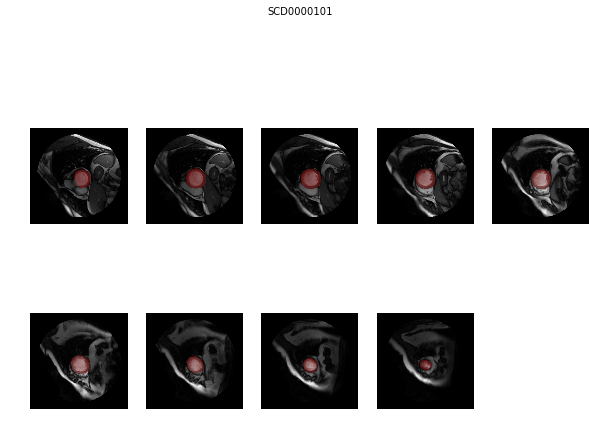

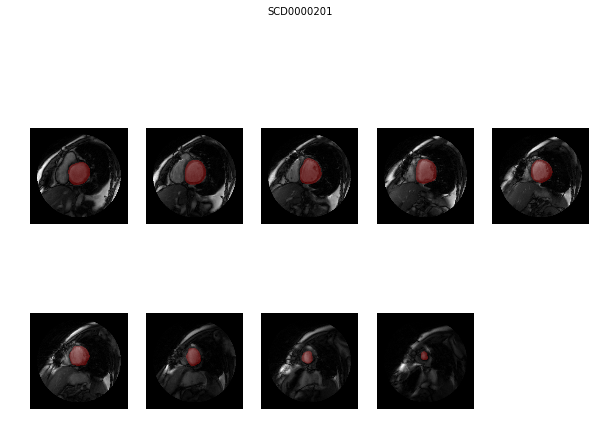

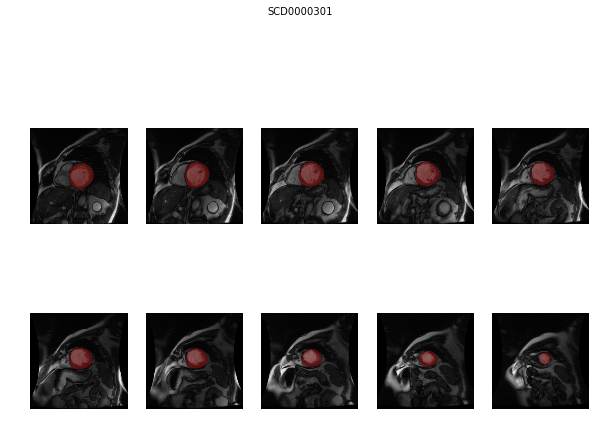

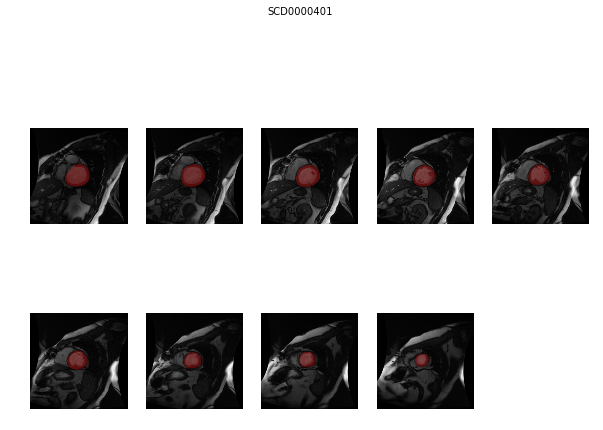

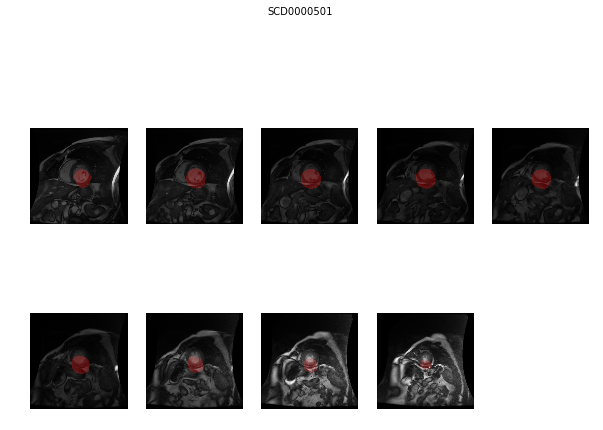

In [17]:
# Using your code from Phase 1, add the parsing of the o-contours into your pipeline.
# set the dir paths
baseDir = '/Users/anitha/Desktop/****/final_data'
try:
    ipDir = np.genfromtxt(os.path.join(baseDir,'link.csv'), delimiter=',', usecols=(0,1), dtype=str,skip_header=True)
except IOError:
    print("unable to read/find the link csv file")
    sys.exit(1)
for ind in range(len(ipDir)):
    curDcmDir = os.path.join(baseDir,'dicoms/'+ipDir[ind][0])
    curConDir = os.path.join(baseDir,'contourfiles/'+ipDir[ind][1]+"/o-contours")
    trainCSV = os.path.join(os.path.split(curConDir)[0],'o_imgContPair.csv')
    bDir = os.path.split(curConDir)[0]
    laneMask = genTrainPair(curDcmDir,curConDir,trainCSV)
    chkMask(curDcmDir,curConDir,bDir,trainCSV)

#### After building the pipeline, please discuss any changes that you made to the pipeline you built in Phase 1, 
#### and why you made those changes.
I changed the naming convention for writing the pairCSV: previously I had it as imgContPair.csv, currently changed it to i_imgContPair.csv and o_imgContPair.csv
I also changed the input signature for the chkMask function: chkMask(dcmDir,conDir,opBaseDir,pairCSVFname) to pass the filename for the imgContPair CSV
I fused the dicom and boolean masks to verify if the contours are aligning with the image as shown in the cell above.
The o-contours for the last patient (SC-HF-I-6) doesn't match. Flipping the mask about a central horizontal axis seems to fit better but still not exactly (subplot 1,8,9 don't match. 2,3,6,7 are off by few pixels. 4&5 match well).

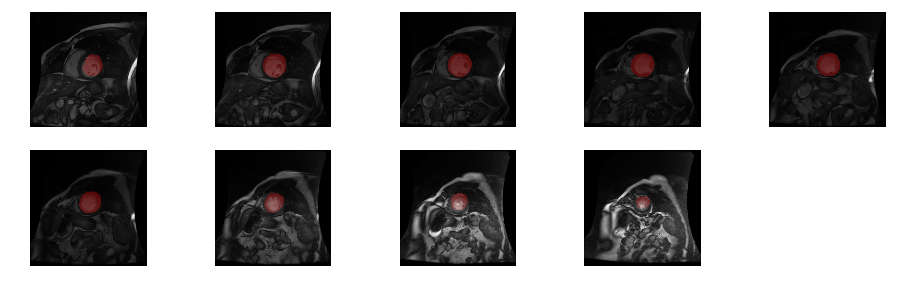

In [18]:
curDcmDir = os.path.join(baseDir,'dicoms/'+ipDir[4][0])
curConDir = os.path.join(baseDir,'contourfiles/'+ipDir[4][1]+"/o-contours")
trainCSV = os.path.join(os.path.split(curConDir)[0],'o_imgContPair.csv')
bDir = os.path.split(curConDir)[0]
laneMask = genTrainPair(curDcmDir,curConDir,trainCSV)

pairCSV = np.genfromtxt(os.path.join(curConDir,trainCSV), delimiter=',', 
                                usecols=(0,1), dtype=str)
n=0
plt.figure(figsize = (16,12))
for i in range(len(pairCSV)):
    curImg = parse_dicom_file(pairCSV[i][0])  
    contMask = createContMask(pairCSV[i][1],curImg['pixel_data'].shape)
    contMask = np.flipud(contMask)
    overImg = overlayImg(curImg,contMask)
    plt.subplot(5,5,n+1)
    n = n+1
    plt.imshow(overImg); plt.axis('off')

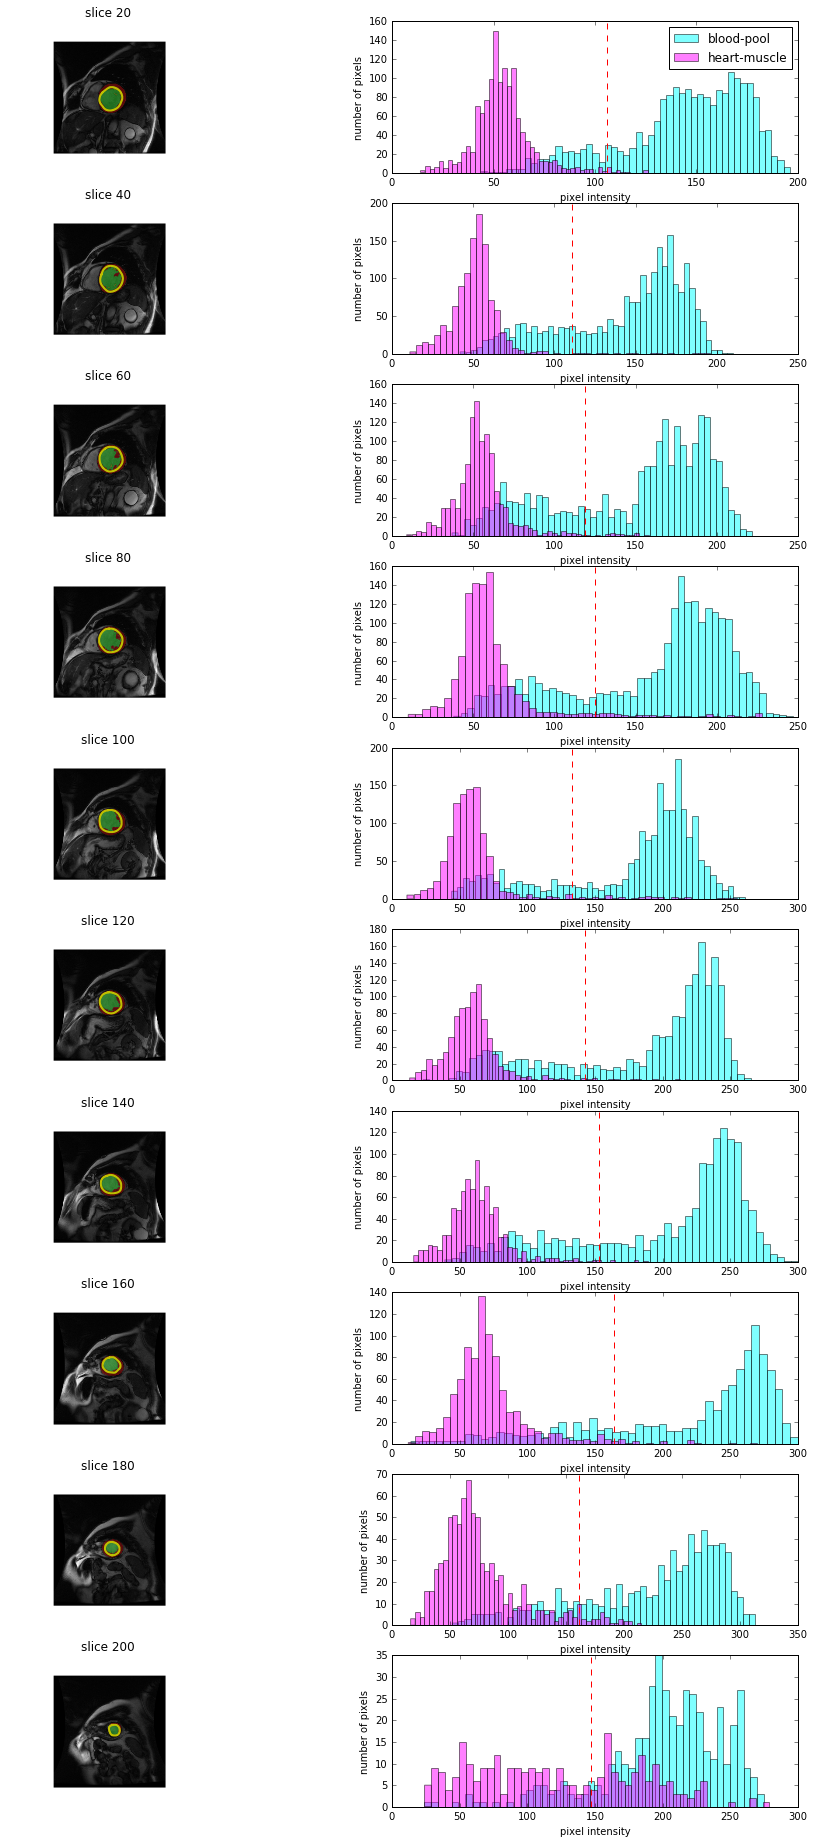

In [19]:
# Let’s assume that you want to create a system to outline the boundary of the blood pool (i-contours), 
# and you already know the outer border of the heart muscle (o-contours). 
from skimage import filters
from scipy import ndimage

diceCoeffWall = []
diceCoeffVen = []
voxInt=[]
plt.figure(figsize=(16,32))
for ind in range(len(ipDir)-1):
    curDcmDir = os.path.join(baseDir,'dicoms/'+ipDir[ind][0])
    curConDir = os.path.join(baseDir,'contourfiles/'+ipDir[ind][1]+"/o-contours")
    bDir = os.path.split(curConDir)[0]
    o_trainCSV = os.path.join(os.path.split(curConDir)[0],'o_imgContPair.csv')
    o_pairCSV = np.genfromtxt(os.path.join(curConDir[ind],o_trainCSV), delimiter=',', usecols=(0,1), dtype=str) 
    i_trainCSV = os.path.join(os.path.split(curConDir)[0],'i_imgContPair.csv')
    i_pairCSV = np.genfromtxt(os.path.join(curConDir,i_trainCSV), delimiter=',', usecols=(0,1), dtype=str)
    matchFnames = getMatchCont(i_pairCSV,o_pairCSV)
    n=1
    curDiceWall = np.zeros([len(matchFnames),2])
    curDiceVen = np.zeros([len(matchFnames),2])
    for i in range(len(matchFnames)):
        curImg = parse_dicom_file(matchFnames[i][1]) 
        #curImg = anisodiff(curImg['pixel_data'],niter=25,kappa=50,gamma=0.2,step=(1.,1.),option=2,ploton=False)
        iMask = createContMask(matchFnames[i][2],curImg['pixel_data'].shape)
        oMask = createContMask(matchFnames[i][3],curImg['pixel_data'].shape)
        thickMask = np.bitwise_xor(oMask,iMask)*1
        
        oInd = np.where(oMask==1)
        imgVec = curImg['pixel_data'][oInd]
        thresh = filters.threshold_otsu(imgVec)  
        # higher intensities represent blood-pool, lower intensities represent heart wall
        walltmp = oMask*0
        walltmp[oInd[0][imgVec<=thresh],oInd[1][imgVec<=thresh]] = 1
        bloodtmp = oMask*0
        bloodtmp[oInd[0][imgVec>thresh],oInd[1][imgVec>thresh]]=1
        bloodtmp = ndimage.binary_fill_holes(bloodtmp)
        curDiceWall[i,0] = matchFnames[i][0]
        curDiceWall[i,1] = getDiceCoeff(walltmp,thickMask)
        curDiceVen[i,0] = matchFnames[i][0]
        curDiceVen[i,1] = getDiceCoeff(bloodtmp,iMask)
        
        if ind==2:
            x_coord = []
            y_coord = []
            with open(matchFnames[i][2], 'r') as infile:
                for line in infile:
                    coords = line.strip().split()
                    x_coord.append(float(coords[0]))
                    y_coord.append(float(coords[1]))
            walltmp = walltmp*255
            wallMask = np.dstack((walltmp,oMask,oMask)).astype('uint8')
            bloodtmp = bloodtmp*255
            bloodMask = np.dstack((oMask*0,bloodtmp,oMask*0)).astype('uint8')
            img = curImg['pixel_data']/np.max(curImg['pixel_data'])
            img = (img*255).astype('uint8')
            imgRGB = np.dstack((img,img,img))
            fusedImg = imgRGB
            fusedImg[oInd]=(0.7*imgRGB[oInd] + 0.3*wallMask[oInd] + 0.3*bloodMask[oInd]).astype('uint8')
            plt.subplot(10,2,n); plt.imshow(fusedImg); plt.axis('off')
            plt.subplot(10,2,n); plt.plot(x_coord,y_coord,'-y',linewidth=2)
            plt.title("slice "+str(matchFnames[i][0]))
            n=n+1
    
            iInd = np.where(iMask==1)
            ax = plt.subplot(10,2,n)
            nPix,bins,patches = plt.hist(curImg['pixel_data'][iInd],bins=50,alpha=0.5,facecolor='cyan',label='blood-pool')
            thickInd = np.where(thickMask==1)
            nPix,bins,patches = plt.hist(curImg['pixel_data'][thickInd],bins=50,alpha=0.5,facecolor='magenta',label='heart-muscle')
            plt.xlabel("pixel intensity"); plt.ylabel("number of pixels")
            ax.axvline(x=thresh, color='r', linestyle='dashed', linewidth=1)
            if (n==2): plt.legend(loc=0)
            n = n+1
            voxInt.extend(imgVec)
    diceCoeffWall.append(curDiceWall)
    diceCoeffVen.append(curDiceVen)

#### Compare the differences in pixel intensities inside the blood pool (inside the i-contour) 
#### to those inside the heart muscle (between the i-contours and o-contours)
The histogram of the pixel intensities in the heart muscle and blood pool of the images of a single patient are plotted in the cell above. The histograms of the two regions overlap significantly. In the slices with larger cross-section of the heart (lower slice numbers) the histograms have relatively less overlap than the last slice with smaller cross section.
#### could you use a simple thresholding scheme to automatically create the i-contours, given the 
#### o-contours? Why or why not? Show figures that help justify your answer.
From the histograms above, there is no single universal threshold for segmenting the blood pool from the heart muscle. I segmented the two regions using Otsu-thresholding (assumes a bi-modal distribution, which fits this case), and the thresholds are shown by the red vertical line in the histograms above. Dice doefficient and Jaccard Index are the commonly used metrics for estimating the degree of agreement between the predicted labels and ground-truth labels. I used dice coefficient and they are plotted below for the first four patients (fifth patient excluded due to the mismatch in the ground truth contours). It can be seen that there is decent agreement of the segmented blood pool with the ground truth labels as seen by higher Dice coefficient (>80%) for most of the slices except the last one. The heart muscle segmentation is slightly worse than the blood pool segmentation which might be due to the lower area of that region. 

The edges of thresholding based segmentation maps tended to be noisier and not smooth as expected from the ground-truth contours (yellow contours in the above figure). To smoothen the contours, I tried anisotropic diffusion filtering the image and thresholding the filtered image. Anisotropic filtering smoothed the edges (preserves the strong edges but removes weaker edges) but didnot improve the performance of thresholding based segmentation (the difference in Dice coefficient were minimal and hence are not reported here)

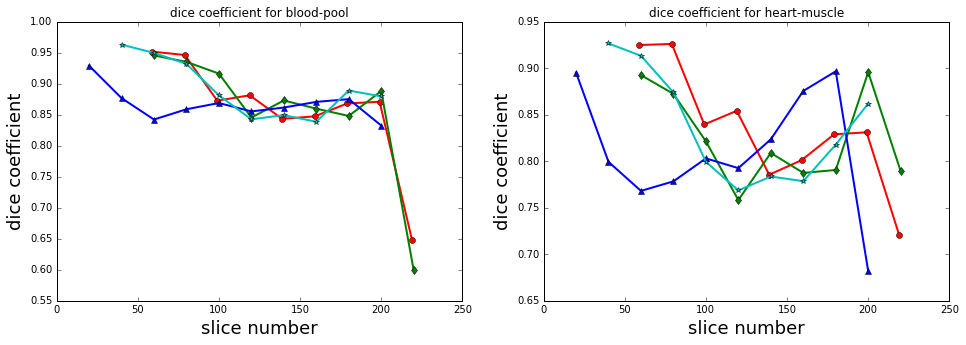

In [20]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(diceCoeffVen[0][:,0],diceCoeffVen[0][:,1],'-or',diceCoeffVen[1][:,0],diceCoeffVen[1][:,1],'-dg',
        diceCoeffVen[2][:,0],diceCoeffVen[2][:,1],'-^b',diceCoeffVen[3][:,0],diceCoeffVen[3][:,1],'-*c',linewidth=2)
plt.xlabel('slice number',fontsize = 18); plt.ylabel('dice coefficient',fontsize = 18)
plt.title("dice coefficient for blood-pool")
plt.subplot(122)
plt.plot(diceCoeffWall[0][:,0],diceCoeffWall[0][:,1],'-or',diceCoeffWall[1][:,0],diceCoeffWall[1][:,1],'-dg',
        diceCoeffWall[2][:,0],diceCoeffWall[2][:,1],'-^b',diceCoeffWall[3][:,0],diceCoeffWall[3][:,1],'-*c',linewidth=2)
plt.xlabel('slice number',fontsize = 18); plt.ylabel('dice coefficient',fontsize = 18)
plt.title("dice coefficient for heart-muscle")

[0, 256, 256, 0]

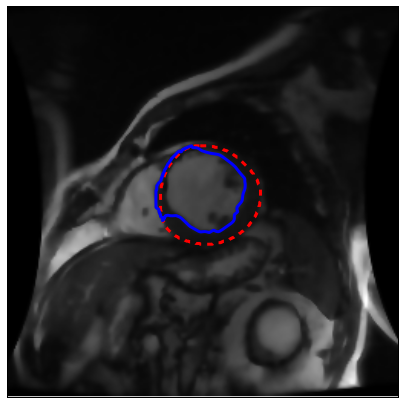

In [21]:
# lets pick an example image and see how SNAKES perform:
# Performance is not reliable and cannot control the direction of propogation, which seems random 
# (for a piece of the curve normals are pointing inside and for the remaining curve it is pointing outside)
from skimage.segmentation import active_contour
from scipy import ndimage

ocFname = '/Users/anitha/Desktop/Arterys/final_data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0080-ocontour-manual.txt'
ipFname = '/Users/anitha/Desktop/Arterys/final_data/dicoms/SCD0000301/80.dcm'
currImg = parse_dicom_file(ipFname)
tst = anisodiff(currImg['pixel_data'],niter=5,kappa=50,gamma=0.2,step=(1.,1.),option=2,ploton=False)
tst = tst/np.max(tst)
oMask = createContMask(ocFname,curImg['pixel_data'].shape)
#oMask = ndimage.grey_dilation(oMask, size=(15,15))
#tst = tst*oMask
x_coord = []
y_coord = []
with open(ocFname, 'r') as infile:
    for line in infile:
        coords = line.strip().split()
        x_coord.append(float(coords[0]))
        y_coord.append(float(coords[1]))
init = np.array([x_coord, y_coord]).T
snake = active_contour(tst, init, alpha=0.2, beta=8, gamma=0.002)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
plt.gray()
ax.imshow(tst)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, currImg['pixel_data'].shape[1],currImg['pixel_data'].shape[0], 0])

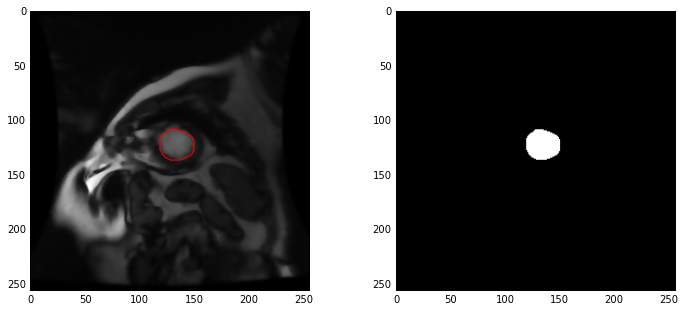

In [22]:
# try a level-set implementation, more stable than snakes
from morphsnakes import *
ocFname = '/Users/anitha/Desktop/Arterys/final_data/contourfiles/SC-HF-I-4/o-contours/IM-0001-0180-ocontour-manual.txt'
ipFname = '/Users/anitha/Desktop/Arterys/final_data/dicoms/SCD0000301/180.dcm'
curImg = parse_dicom_file(ipFname)
tst = anisodiff(curImg['pixel_data'],niter=5,kappa=50,gamma=0.2,step=(1.,1.),option=2,ploton=False)
tst = tst/np.max(tst)
oMask = createContMask(ocFname,curImg['pixel_data'].shape)
gI = gborders(tst, alpha=400, sigma=5.48)
mgac = MorphACWE(tst, smoothing=3, lambda1=20, lambda2=1)
mgac.levelset = oMask

plt.figure(figsize=(12, 5))
lvl = evolve_visual(mgac, num_iters=8, background=tst,ploton=True)

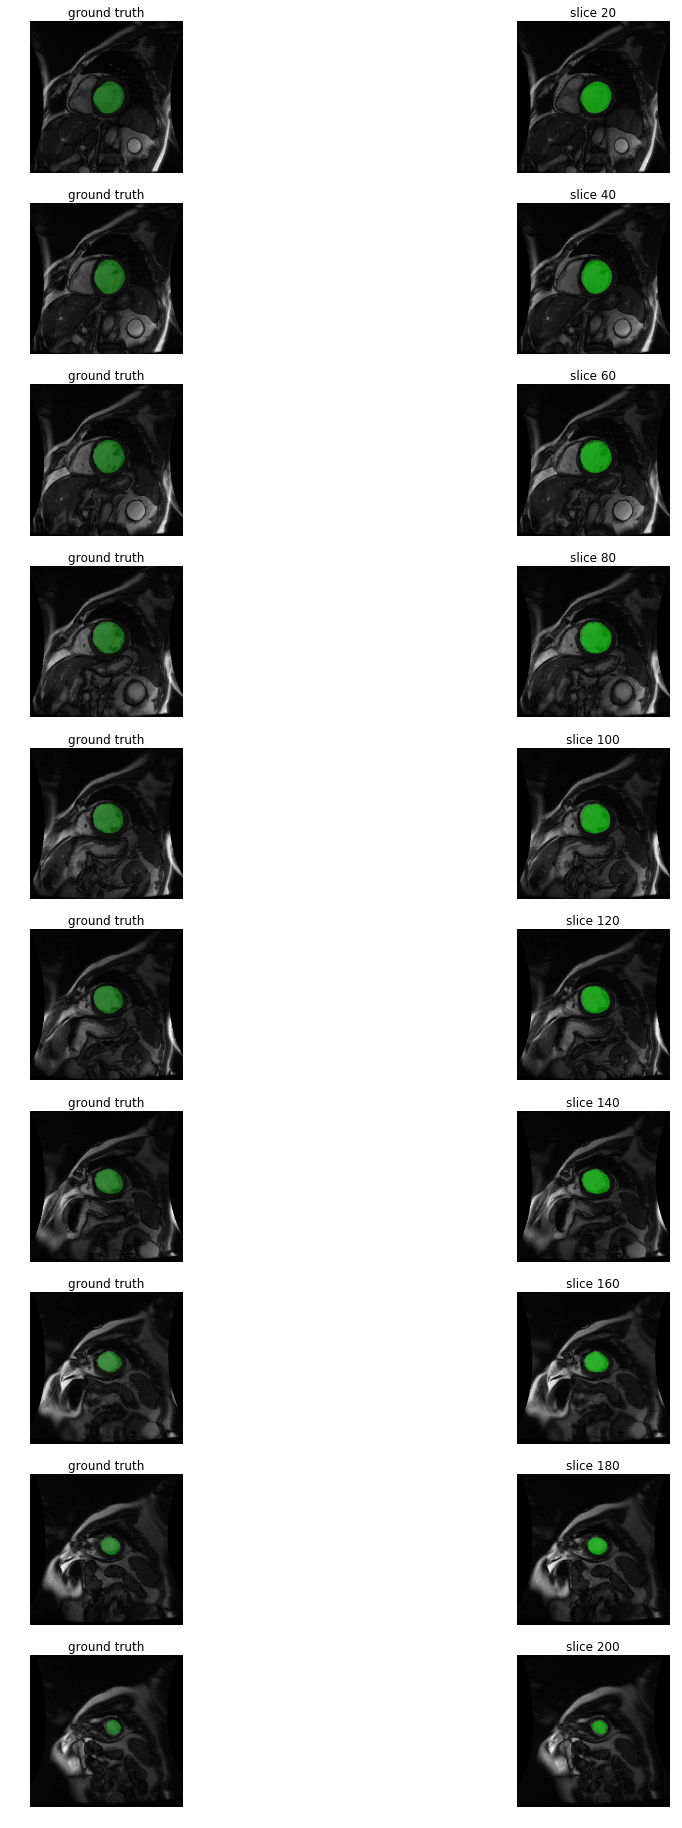

In [23]:
diceCoeffWallLS = []
diceCoeffVenLS = []
plt.figure(figsize=(16,32))
for ind in range(len(ipDir)-1):
    curDcmDir = os.path.join(baseDir,'dicoms/'+ipDir[ind][0])
    curConDir = os.path.join(baseDir,'contourfiles/'+ipDir[ind][1]+"/o-contours")
    bDir = os.path.split(curConDir)[0]
    o_trainCSV = os.path.join(os.path.split(curConDir)[0],'o_imgContPair.csv')
    o_pairCSV = np.genfromtxt(os.path.join(curConDir[ind],o_trainCSV), delimiter=',', usecols=(0,1), dtype=str) 
    i_trainCSV = os.path.join(os.path.split(curConDir)[0],'i_imgContPair.csv')
    i_pairCSV = np.genfromtxt(os.path.join(curConDir,i_trainCSV), delimiter=',', usecols=(0,1), dtype=str)
    matchFnames = getMatchCont(i_pairCSV,o_pairCSV)
    n=1
    curDiceWall = np.zeros([len(matchFnames),2])
    curDiceVen = np.zeros([len(matchFnames),2])
    for i in range(len(matchFnames)):
        curImg = parse_dicom_file(matchFnames[i][1]) 
        curImg = curImg['pixel_data']
        #curImg = anisodiff(curImg['pixel_data'],niter=5,kappa=50,gamma=0.2,step=(1.,1.),option=2,ploton=False)
        iMask = createContMask(matchFnames[i][2],curImg.shape)
        oMask = createContMask(matchFnames[i][3],curImg.shape)
        thickMask = np.bitwise_xor(oMask,iMask)*1
        
        curImg = curImg/np.max(curImg)
        gI = gborders(curImg, alpha=400, sigma=5.48)
        mgac = MorphACWE(curImg, smoothing=3, lambda1=20, lambda2=1)
        mgac.levelset = oMask
        lvl = evolve_visual(mgac, num_iters=8, background=curImg,ploton=False)
        lvl = lvl.astype("uint8")
        walltmp = np.bitwise_xor(oMask,lvl)*1
        curDiceVen[i,0] = matchFnames[i][0]
        curDiceVen[i,1] = getDiceCoeff(lvl,iMask)
        curDiceWall[i,0] = matchFnames[i][0]
        curDiceWall[i,1] = getDiceCoeff(walltmp,thickMask)
        
        if ind==2:
            iInd = np.where(iMask==1)
            bloodtmp = iMask*255
            bloodMask = np.dstack((iMask,bloodtmp,iMask)).astype('uint8')
            img = (curImg*255).astype('uint8')
            imgRGB = np.dstack((img,img,img))
            fusedImg = imgRGB
            fusedImg[iInd]=(0.7*imgRGB[iInd] + 0.3*bloodMask[iInd]).astype('uint8')
            plt.subplot(10,2,n); plt.imshow(fusedImg); plt.axis('off'); plt.title("ground truth")
            n=n+1
            
            lvlInd = np.where(lvl==1)
            fusedImg0 = imgRGB.copy()
            lvltmp = lvl*255
            lvlMask = np.dstack((lvl,lvltmp,lvl)).astype('uint8')
            fusedImg0[lvlInd]=(0.7*imgRGB[lvlInd] + 0.3*lvlMask[lvlInd]).astype('uint8')
            plt.subplot(10,2,n); plt.imshow(fusedImg0); plt.axis('off')
            plt.title("slice "+str(matchFnames[i][0]))
            n = n+1

    diceCoeffWallLS.append(curDiceWall)
    diceCoeffVenLS.append(curDiceVen)

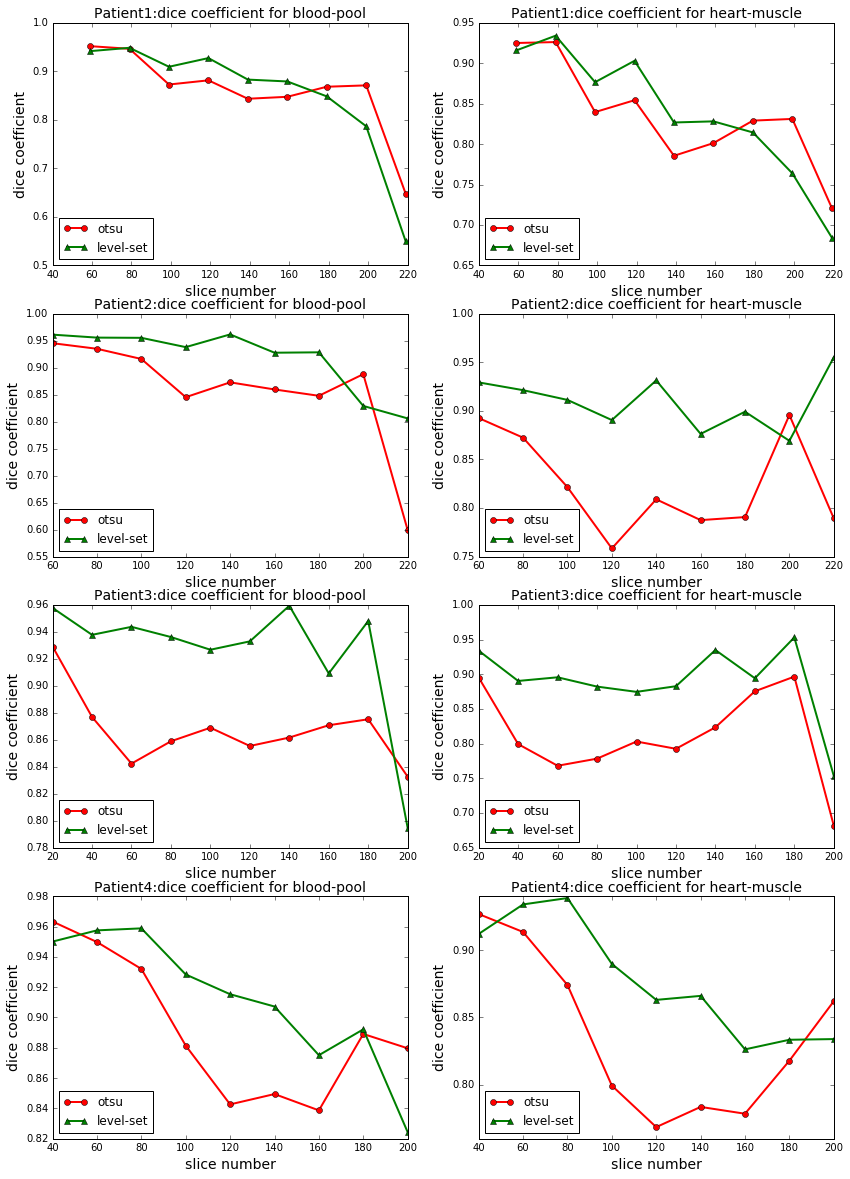

In [30]:
plt.figure(figsize=(14,20))
n=1
for i in range(4):
    plt.subplot(4,2,n)
    plt.plot(diceCoeffVen[i][:,0],diceCoeffVen[i][:,1],'-or',label='otsu',linewidth=2)
    plt.plot(diceCoeffVenLS[i][:,0],diceCoeffVenLS[i][:,1],'-^g',label='level-set',linewidth=2)
    plt.xlabel('slice number',fontsize = 14); plt.ylabel('dice coefficient',fontsize = 14)
    plt.title("Patient"+str(i+1)+":dice coefficient for blood-pool",fontsize = 14)
    plt.legend(loc=3)
    n= n+1
    
    plt.subplot(4,2,n)
    plt.plot(diceCoeffWall[i][:,0],diceCoeffWall[i][:,1],'-or',label='otsu',linewidth=2)
    plt.plot(diceCoeffWallLS[i][:,0],diceCoeffWallLS[i][:,1],'-^g',label='level-set',linewidth=2)
    plt.xlabel('slice number',fontsize = 14); plt.ylabel('dice coefficient',fontsize = 14)
    plt.title("Patient"+str(i+1)+":dice coefficient for heart-muscle",fontsize = 14)
    plt.legend(loc=3)
    n = n+1

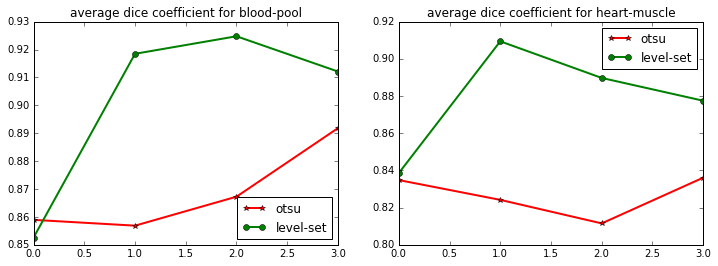

In [12]:
plt.figure(figsize=(12,4))
plt.subplot(121);plt.plot(range(4),[np.mean(diceCoeffVen[i][:,1]) for i in range(4)],'-*r',label="otsu",linewidth=2)
plt.subplot(121);plt.plot(range(4),[np.mean(diceCoeffVenLS[i][:,1]) for i in range(4)],'-og',label="level-set",linewidth=2)
plt.title("average dice coefficient for blood-pool"); plt.legend(loc=0)
plt.subplot(122);plt.plot(range(4),[np.mean(diceCoeffWall[i][:,1]) for i in range(4)],'-*r', label="otsu",linewidth=2)
plt.subplot(122);plt.plot(range(4),[np.mean(diceCoeffWallLS[i][:,1]) for i in range(4)],'-og',label="level-set",linewidth=2)
plt.title("average dice coefficient for heart-muscle"); plt.legend(loc=0)

#### Do you think that any other heuristic (non-machine learning)-based approaches, besides simple thresholding, would work in this case? Explain.
Active contours based segmentation will perform better than simple thresolding (see the plots in the cell above). I tried the default implementation of Snakes in skimage. Snake is a simpler energy minimizing spline constrained externally by smoothness and continuity constraints on the curve and internally by image forces drawing it towards edges/gradients. This implementation didn't meet the needs for the current task as the direction of curve propagation is not consistent across time-steps (in the sense that the curves is not consistently expanding or shrinking).

Snakes are highly sensitive to noise and initialization and level-set based approaches usually perform better than snakes. There are many variations of this approach. I used an open-source implementation of 2d level-sets. Level-sets embed the segmentation as a zeroth-order level set (level-set/curve at t=0) of a higher dimensional volume (for ex. a circle is a zeroth order level-set of a sphere). For this task, on average, the level-set based segmentation performs marginally better (5-10%) than thresholding. 

Both the approaches are not reliable when segmenting the apex of the heart (slices with smaller cross-section). A 3D level-set could potentially improve segmentation of these regions. 